In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Activation, AveragePooling2D, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.engine.topology import Layer

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
def unet_down_block(x, n_filters, block_id, with_maxpool=True, activation="elu"):
    y = Conv2D(n_filters, (3, 3), activation=activation, 
               padding='valid', name="conv{}_1".format(block_id))(x)
    print(y.shape)
    #y = BatchNormalization(name="bn{}_1".format(block_id))(y)
    
    y = Conv2D(n_filters, (3, 3), activation=activation,
               padding='valid', name="conv{}_2".format(block_id))(y)
    #conv = BatchNormalization(name="bn{}_2".format(block_id))(y)
    print(y.shape)
    if not with_maxpool:
        return y
    
    pool = MaxPooling2D(pool_size=(2, 2), name="max_pool{}".format(block_id))(y)
    print(pool.shape)
    return y, pool    

In [7]:
def unet_up_block(x, y, n_filters, block_id, activation="elu"):
    up_x = UpSampling2D(size=(2, 2), name="upsample{}".format(block_id))(x)
    
    # Compute crop needed to have the same shape for up_x and y
    _, hx, wx, _ = up_x.shape
    _, hy, wy, _ = y.shape
    cropy = int(hy - hx)//2
    cropx = int(wy - wx)//2
    crop_y = Cropping2D(cropping=((cropy, cropy), (cropx, cropx)),
                        name="crop{}".format(block_id))(y)
    print("Crop: ", cropy, cropx)
    up = concatenate([up_x, crop_y], axis=-1,
                     name="concat{}".format(block_id))
    print(up.shape)
    up = Conv2D(n_filters, (3, 3), 
                activation=activation,
                padding='valid',
                name="conv{}_1".format(block_id))(up)
    print(up.shape)
    up = Conv2D(n_filters, (3, 3),
                activation=activation,
                padding='valid',
                name="conv{}_2".format(block_id))(up)
    print(up.shape)
    return up

In [8]:
class OHELayer(Layer):

    def __init__(self, n_classes, **kwargs):
        self.n_classes = n_classes
        super(OHELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(OHELayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        x = K.argmax(x, axis=-1)
        return K.one_hot(x, num_classes=self.n_classes)

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = {'n_classes': self.n_classes}
        base_config = super(OHELayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
class SumLayer(Layer):

    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SumLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.sum(K.sum(x, axis=1), axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], ) + (input_shape[-1], )
    
    def get_config(self):
        base_config = super(SumLayer, self).get_config()
        return base_config

In [10]:
def get_unet(im_height, im_width, n_channels=3, n_classes=6,
             n_filters=[64, 128, 256, 512, 1024]):
    inputs = Input((im_height, im_width, n_channels))
    
    conv1, pool1 = unet_down_block(inputs, n_filters[0], 1)
    conv2, pool2 = unet_down_block(pool1,  n_filters[1], 2)
    conv3, pool3 = unet_down_block(pool2,  n_filters[2], 3)
    conv4, pool4 = unet_down_block(pool3,  n_filters[3], 4)
    conv5 = unet_down_block(pool4, n_filters[4], 5, with_maxpool=False)
    
    conv6 = unet_up_block(conv5, conv4, n_filters[3], 6)
    conv7 = unet_up_block(conv6, conv3, n_filters[2], 7)
    conv8 = unet_up_block(conv7, conv2, n_filters[1], 8)
    conv9 = unet_up_block(conv8, conv1, n_filters[0], 9)
    
    segmentation = Conv2D(n_classes, (1, 1), activation='softmax', name="segmentation")(conv9)
    
    segmentation_ohe = OHELayer(n_classes=6, name="ohe")(segmentation)
    sum_per_type = SumLayer(name="sum")(segmentation_ohe)
    counts = Dense(5, kernel_initializer='constant', name="counts")(sum_per_type)

    model = Model(inputs=[inputs], outputs=[segmentation, counts], name="unet_counts")

    return model

In [11]:
# unet = get_unet( 524, 524, 3, n_filters=[16, 32, 64, 128, 256])
unet = get_unet( 524, 524, 3, n_filters=[16, 32, 64, 128, 256])

(?, 522, 522, 16)
(?, 520, 520, 16)
(?, 260, 260, 16)
(?, 258, 258, 32)
(?, 256, 256, 32)
(?, 128, 128, 32)
(?, 126, 126, 64)
(?, 124, 124, 64)
(?, 62, 62, 64)
(?, 60, 60, 128)
(?, 58, 58, 128)
(?, 29, 29, 128)
(?, 27, 27, 256)
(?, 25, 25, 256)
Crop:  4 4
(?, 50, 50, 384)
(?, 48, 48, 128)
(?, 46, 46, 128)
Crop:  16 16
(?, 92, 92, 192)
(?, 90, 90, 64)
(?, 88, 88, 64)
Crop:  40 40
(?, 176, 176, 96)
(?, 174, 174, 32)
(?, 172, 172, 32)
Crop:  88 88
(?, 344, 344, 48)
(?, 342, 342, 16)
(?, 340, 340, 16)


In [12]:
t = np.ones((1, 524, 524, 3))
seg, counts = unet.predict(t)
print("Segmentation output: ", seg.shape)
print("Counts output: ", counts.shape)

Segmentation output:  (1, 340, 340, 6)
Counts output:  (1, 5)


In [13]:
def get_count_net_from_seg(im_height, im_width, n_channels, unet):
    inputs = Input((im_height, im_width, n_channels))
    x = unet.get_layer(name="ohe")(inputs)
    x = unet.get_layer(name="sum")(x)
    x = unet.get_layer(name="counts")(x)
    model = Model(inputs=[inputs], outputs=[x], name="unet_counts")
    return model

In [14]:
cnt_net = get_count_net_from_seg(340, 340, 6, unet)

In [15]:
cnt_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 340, 340, 6)       0         
_________________________________________________________________
ohe (OHELayer)               (None, 340, 340, 6)       0         
_________________________________________________________________
sum (SumLayer)               (None, 6)                 0         
_________________________________________________________________
counts (Dense)               (None, 5)                 35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [16]:
(524 - 340)/2

92.0

In [17]:
unet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 524, 524, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 522, 522, 16)  448                                          
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 520, 520, 16)  2320                                         
____________________________________________________________________________________________________
max_pool1 (MaxPooling2D)         (None, 260, 260, 16)  0                                            
___________________________________________________________________________________________

In [18]:
class NonValidPatch(Exception):
    pass

In [20]:
class SegIterator(Iterator):
    def __init__(self, root_dir, image_ids,
                 class_weights,
                 n_samples_per_image=160,
                 target_size=(340, 340),
                 batch_size=16, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 8
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
        super(SegIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)

    def random_transform(self, x):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
        if flips[1]:
            x = np.flipud(x)
        if flips[2]:
            x = np.fliplr(x)
        return x

    def get_dots_in_patch(self, sx, sy, dots):
        dots_in_patch = [[] for _ in dots]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if sx <= x < sx + self.target_size[1] and sy <= y < sy + self.target_size[0]:
                    dots_in_patch[i].append((x - sx, y - sy))
        return dots_in_patch
    
    def build_counts(self, dots):
        counts = np.zeros((5, ), dtype=np.int32)
        for c, ds in enumerate(dots):
            counts[c] = len(ds)
        return counts
          
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample(self, shape, dots, image_id):
        margin = 30
        max_iterations = self.n_samples_per_block * 5
        
        smap = np.load(os.path.join(self.root_dir, "TrainSegmentationIgnored2xB", str(image_id) + ".npz"))["smap"]                                                                          
        n_samples = 0
        bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1]), dtype=np.uint8)
        bcounts = np.zeros((self.n_samples_per_block, 5))

        current_iteration = 0
        weights = self.get_weights(dots)
        
        # Samples n dots, with some probabilty to get the background only
        while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
            current_iteration += 1
            try:
                # Choose an output class randomly
                output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=weights)[0]
                
                # Background, select randomly a patch in the image (high chance to get only background)
                if output_class == self.n_sealion_types:
                    sx_min = 0
                    sx_max = shape[1] - self.target_size[1]
                    sy_min = 0
                    sy_max = shape[0] - self.target_size[0]
                # Choose a dot randomly in that class
                else:  
                    dot_index = np.random.randint(0, len(dots[output_class]))
                    rx, ry = dots[output_class][dot_index]
                    sx_min = min(max(0, rx - self.target_size[1] + margin), shape[1] - self.target_size[1])
                    sx_max = min(max(0, rx - margin), shape[1] - self.target_size[1])
                    sy_min = min(max(0, ry - self.target_size[0] + margin), shape[0] - self.target_size[1])
                    sy_max = min(max(0, ry - margin), shape[0] - self.target_size[0]) 
                
                    if sx_min >= sx_max:
                        sx_min = min(max(0, rx - self.target_size[1]), shape[1] - self.target_size[1])
                        sx_max = min(max(0, rx), shape[1] - self.target_size[1])
                        
                    if sy_min >= sy_max:
                        sy_min = min(max(0, ry - self.target_size[0]), shape[0] - self.target_size[1])
                        sy_max = min(max(0, ry), shape[0] - self.target_size[0]) 
                    
                if sx_min >= sx_max or sy_min >= sy_max:
                        continue
                        
                # Choose the top-left corner so that the dot selected is in the patch.
                sx = np.random.randint(sx_min, sx_max)
                sy = np.random.randint(sy_min, sy_max)

                dots_in_patch = self.get_dots_in_patch(sx, sy, dots)
                
                spatch = smap[sy:sy + self.target_size[0],
                              sx:sx + self.target_size[1]]
                spatch[spatch==6] = 5
                counts = self.build_counts(dots_in_patch)
                bx[n_samples, ...] = spatch
                bcounts[n_samples, ...] = counts
                n_samples += 1
            except NonValidPatch:
                continue
                    
        if current_iteration < max_iterations:
            return bx, bcounts
        else:
            print("Error with image ", image_id)
            raise Exception("hoho")
    
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1]),
                           dtype=np.int32)
        batch_counts = np.zeros((current_batch_size * self.n_samples_per_block, 5), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
            
            # Scale dots coordinates
            dots_resized = []
            for ds in dots:
                ds_resized = []
                for (x, y) in ds:
                    ds_resized.append((x//2, y//2))
                dots_resized.append(ds_resized)
                
            shape = (shape[0]//2, shape[1]//2)
                
            x, counts = self.sample(shape, dots_resized, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_counts[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = counts

        b, h, w = batch_x.shape
        batch_x = to_categorical(batch_x, num_classes=self.n_sealion_types + 1).reshape((b, h, w, -1))
        return batch_x, batch_counts

In [21]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights,
                 n_samples_per_image=160,
                 target_size=(524, 524),
                 scale = 1,
                 crop = (92, 92),
                 batch_size=16, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 8
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.crop = crop
        self.scale = scale
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def compute_class_distribution(self, n_batches):
        seg_freqs = defaultdict(int)
        count_freqs = {0: defaultdict(int),
                             1: defaultdict(int),
                             2: defaultdict(int),
                             3: defaultdict(int),
                             4: defaultdict(int)}
        for b in range(n_batches):
            _, [by, bcounts] = self.next()
            by = np.argmax(by, axis=-1)
            ids, freqs = np.unique(by, return_counts=True)
            for i in range(ids.shape[0]):
                seg_freqs[ids[i]] += freqs[i]
            for b in range(bcounts.shape[0]):
                counts = bcounts[b]
                for i in range(counts.shape[0]):
                    count_freqs[i][counts[i]] += 1
        
        return seg_freqs, count_freqs

    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
                     
    def get_dots_in_patch(self, sx, sy, dots):
        dots_in_patch = [[] for _ in dots]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if sx <= x < sx + self.target_size[1] and sy <= y < sy + self.target_size[0]:
                    dots_in_patch[i].append((x - sx, y - sy))
        return dots_in_patch
    
    def build_counts(self, dots):
        counts = np.zeros((5, ), dtype=np.int32)
        for c, ds in enumerate(dots):
            for (x, y) in ds:
                x_ok = self.crop[1] <= x < self.target_size[1] - self.crop[1]
                y_ok = self.crop[0] <= y < self.target_size[0] - self.crop[0]
                if x_ok and y_ok:
                    counts[c] += 1
        return counts
          
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample(self, shape, dots, image_id):
        margin = self.crop[0] + 30
        max_iterations = self.n_samples_per_block * 5
        
        img = cv2.imread(os.path.join(self.root_dir, "Train2x", str(image_id) + ".jpg"))
        smap = np.load(os.path.join(self.root_dir, "TrainSegmentationIgnored2xB", str(image_id) + ".npz"))["smap"]                                                                          
        n_samples = 0
        bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
        by = np.zeros((self.n_samples_per_block,
                       (self.target_size[0] - 2 * self.crop[0])//self.scale,
                       (self.target_size[1] - 2 * self.crop[1])//self.scale),
                     dtype=np.uint8)
        bcounts = np.zeros((self.n_samples_per_block, 5))

        current_iteration = 0
        weights = self.get_weights(dots)
        
        # Samples n dots, with some probabilty to get the background only
        while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
            current_iteration += 1
            try:
                # Choose an output class randomly
                output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=weights)[0]
                
                # Background, select randomly a patch in the image (high chance to get only background)
                if output_class == self.n_sealion_types:
                    sx_min = 0
                    sx_max = shape[1] - self.target_size[1]
                    sy_min = 0
                    sy_max = shape[0] - self.target_size[0]
                # Choose a dot randomly in that class
                else:  
                    dot_index = np.random.randint(0, len(dots[output_class]))
                    rx, ry = dots[output_class][dot_index]
                    sx_min = min(max(0, rx - self.target_size[1] + margin), shape[1] - self.target_size[1])
                    sx_max = min(max(0, rx - margin), shape[1] - self.target_size[1])
                    sy_min = min(max(0, ry - self.target_size[0] + margin), shape[0] - self.target_size[1])
                    sy_max = min(max(0, ry - margin), shape[0] - self.target_size[0]) 
                
                    if sx_min >= sx_max:
                        sx_min = min(max(0, rx - self.target_size[1]), shape[1] - self.target_size[1])
                        sx_max = min(max(0, rx), shape[1] - self.target_size[1])
                        
                    if sy_min >= sy_max:
                        sy_min = min(max(0, ry - self.target_size[0]), shape[0] - self.target_size[1])
                        sy_max = min(max(0, ry), shape[0] - self.target_size[0]) 
                    
                if sx_min >= sx_max or sy_min >= sy_max:
                        continue
                        
                # Choose the top-left corner so that the dot selected is in the patch.
                sx = np.random.randint(sx_min, sx_max)
                sy = np.random.randint(sy_min, sy_max)

                dots_in_patch = self.get_dots_in_patch(sx, sy, dots)
                
                img_patch = img[sy:sy+self.target_size[0], sx:sx+self.target_size[1],:]
                if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                    continue
                spatch = smap[sy + self.crop[0]:sy + self.target_size[0] - self.crop[0],
                              sx + self.crop[1]:sx + self.target_size[1] - self.crop[1]]
                
                counts = self.build_counts(dots_in_patch)
                img_patch, spatch = self.random_transform(img_patch, spatch)
                bx[n_samples, ...] = img_patch
                by[n_samples, ...] = spatch
                bcounts[n_samples, ...] = counts
                n_samples += 1
            except NonValidPatch:
                continue
                    
        if current_iteration < max_iterations:
            return bx, by, bcounts
        else:
            print("Error with image ", image_id)
            raise Exception("hoho")
    
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block,
                            (self.target_size[0] - 2 * self.crop[0])//self.scale,
                            (self.target_size[1] - 2 * self.crop[1])//self.scale),
                           dtype=np.int32)
        batch_counts = np.zeros((current_batch_size * self.n_samples_per_block, 5), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
            
            # Scale dots coordinates
            dots_resized = []
            for ds in dots:
                ds_resized = []
                for (x, y) in ds:
                    ds_resized.append((x//2, y//2))
                dots_resized.append(ds_resized)
                
            shape = (shape[0]//2, shape[1]//2)
                
            x, y, counts = self.sample(shape, dots_resized, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 
            batch_counts[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = counts
        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                cv2.imwrite(os.path.join(self.debug_dir, "smap_{}.jpg".format(i)), to_img(batch_y[i]))
        
        b, h, w = batch_y.shape
        batch_y = to_categorical(batch_y, num_classes=self.n_sealion_types + 2).reshape((b, h, w, -1))
        return self.normalize_input(batch_x), [batch_y, batch_counts]

In [23]:
with open("../../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [24]:
class_weights = [1, 1, 0.2, 0.8, 0.7, 0.01]

In [25]:
trainSegGenerator = SegIterator("/home/lowik/sealion/data/sealion", train_ids, class_weights)
valSegGenerator = SegIterator("/home/lowik/sealion/data/sealion", train_ids, class_weights)

In [26]:
for batch_seg, batch_counts in valSegGenerator:
    break

In [27]:
print("Seg shape: ", batch_seg.shape)
print("Counts shape: ", batch_counts.shape)

Seg shape:  (16, 340, 340, 6)
Counts shape:  (16, 5)


In [28]:
counts_pred = cnt_net.predict(batch_seg)

True counts:  [1 3 0 0 0]
Pred counts:  [ 0.  0.  0.  0.  0.]


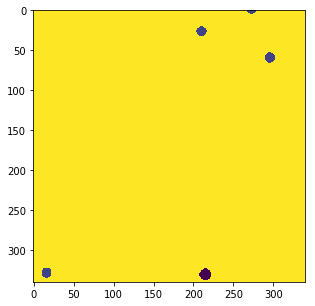

In [29]:
i = 14
plt.figure(figsize=(5, 5))
plt.imshow(np.argmax(batch_seg[i, ...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [30]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion", train_ids, class_weights)
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion", val_ids, class_weights)

In [31]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break

In [32]:
print("X shape: ", batch_x.shape)
print("Y shape: ", batch_y.shape)
print("Counts shape: ", batch_counts.shape)

X shape:  (16, 524, 524, 3)
Y shape:  (16, 340, 340, 7)
Counts shape:  (16, 5)


In [33]:
y_pred, counts_pred = unet.predict(batch_x, batch_size=1)

In [34]:
print("counts_pred shape: ", counts_pred.shape)
print("Y pred shape: ", y_pred.shape)

counts_pred shape:  (16, 5)
Y pred shape:  (16, 340, 340, 6)


True counts:  [ 2  1 19  0 10]
Pred counts:  [ 0.  0.  0.  0.  0.]


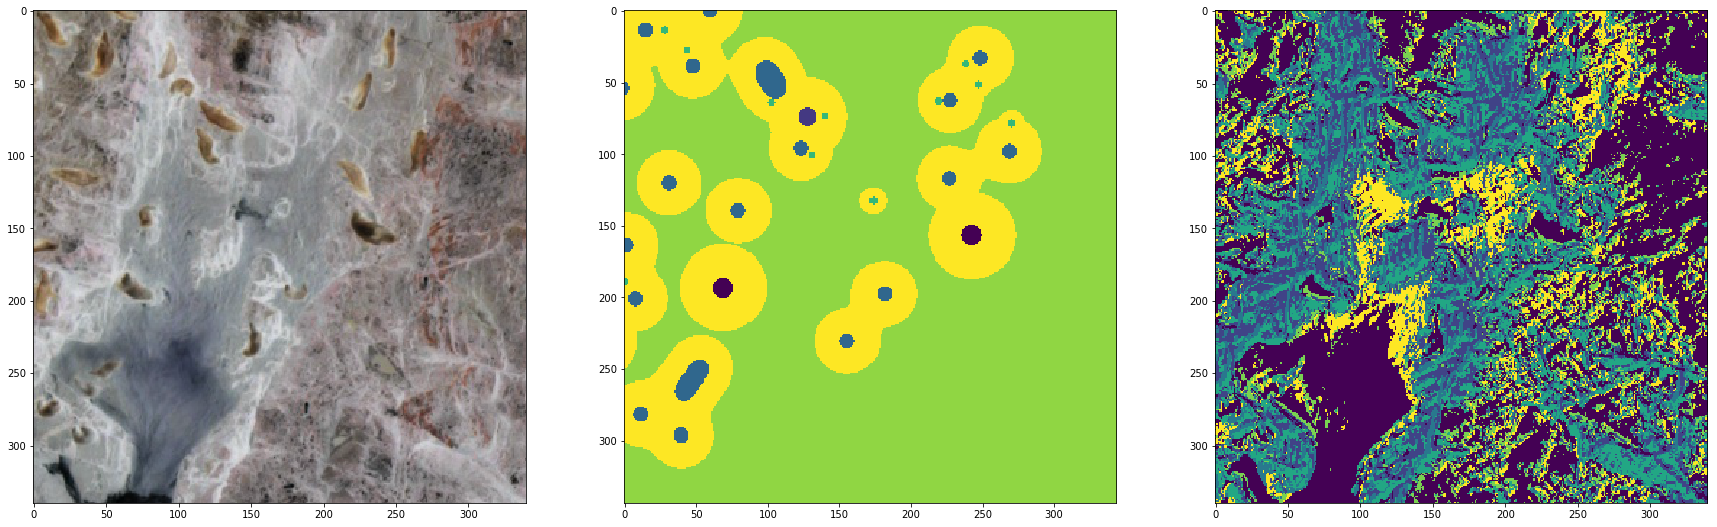

In [35]:
i = 8
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,92:-92,92:-92, :]))
plt.subplot(132)
plt.imshow(cv2.resize(np.argmax(batch_y[i,...], axis=-1).astype(np.uint8), (172*2, 172*2), interpolation=cv2.INTER_NEAREST))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [37]:
seg_distribution, counts_distribution = trainPatchesGenerator.compute_class_distribution(200)

In [41]:
pixels_freq = np.zeros((6,))
for c, f in seg_distribution.items():
    if c < 6:
        pixels_freq[c] = f

In [42]:
pixels_freq

array([  5.33711000e+05,   5.18174000e+05,   4.35578700e+06,
         1.31333900e+06,   1.38745000e+05,   3.18384697e+08])

In [45]:
median = np.median(pixels_freq)

In [59]:
weights_per_class = np.array(list(median/pixels_freq) + [0]) * 10

In [60]:
weights_per_class

array([  1.73038405e+01,   1.78226812e+01,   2.12022535e+00,
         7.03188590e+00,   6.65627590e+01,   2.90065763e-02,
         0.00000000e+00])

In [61]:
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = K.max(y_true * weights_per_class, axis=-1)
    # Add the class ignored to the prediction, so that we can compute categorical_crossentropy
    y_pred_pad = tf.pad(y_pred, [[0, 0], [0, 0], [0, 0], [0, 1]])
    loss_per_pixel = K.categorical_crossentropy(y_pred_pad, y_true)
    #return K.mean(loss_per_pixel * weights)
    return loss_per_pixel * weights

In [62]:
def accuracy_ignored(y_true, y_pred):
    IGNORED = 6 # counts_true.shape[-1] - 1
    # B x H x W, 0 for ignored pixel, 1 otherwise
    not_ignored = K.cast(K.not_equal(K.argmax(y_true, axis=-1),
                                     IGNORED),
                         K.floatx())
    # B x H x W, 1 for correctly classified pixel, 0 otherwise
    correct_pixels = K.cast(K.equal(K.argmax(y_true, axis=-1),
                                    K.argmax(y_pred, axis=-1)),
                            K.floatx())
    # B x H x W, 1 for correctly classified AND not ignored pixel, 0 otherwise
    correct_not_ignored_pixels = correct_pixels * not_ignored
    num_not_ignored = K.sum(not_ignored)
    
    return K.sum(correct_not_ignored_pixels)/num_not_ignored

In [65]:
def accuracy_pups(y_true, y_pred):
    PUPS = 4 # counts_true.shape[-1] - 1
    # B x H x W, 0 for ignored pixel, 1 otherwise
    not_ignored = K.cast(K.equal(K.argmax(y_true, axis=-1),
                                     PUPS),
                         K.floatx())
    # B x H x W, 1 for correctly classified pixel, 0 otherwise
    correct_pixels = K.cast(K.equal(K.argmax(y_true, axis=-1),
                                    K.argmax(y_pred, axis=-1)),
                            K.floatx())
    # B x H x W, 1 for correctly classified AND not ignored pixel, 0 otherwise
    correct_not_ignored_pixels = correct_pixels * not_ignored
    num_not_ignored = K.sum(not_ignored)
    return K.sum(correct_not_ignored_pixels)/(num_not_ignored + K.epsilon())

In [63]:
!rm -rf /home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/*

In [64]:
y_trueK = K.constant(batch_y)
y_predK = K.constant(batch_seg)
with sess.as_default():
    print(np.mean(weighted_categorical_crossentropy(y_trueK, y_predK).eval()))

1.87484


In [37]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/log_tb", batch_freq=10)

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/log_tb", batch_freq=10)

Don't train the counts layers

In [38]:
unet.get_layer(name="counts").trainable = False

In [39]:
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[1.0, 0.0], metrics=[accuracy_ignored, accuracy_pups])

In [40]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_init_seg_{epoch:02d}-{val_loss:.2f}.h5")

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/5
200/200 [==============================] - 383s - loss: 0.7206 - segmentation_loss: 0.7206 - counts_loss: 88.5676 - segmentation_accuracy_ignored: 0.5272 - counts_accuracy_ignored: 0.1800 - val_loss: 0.5910 - val_segmentation_loss: 0.5910 - val_counts_loss: 79.1122 - val_segmentation_accuracy_ignored: 0.7107 - val_counts_accuracy_ignored: 0.1919
Epoch 2/5
200/200 [==============================] - 377s - loss: 0.6123 - segmentation_loss: 0.6123 - counts_loss: 117.1365 - segmentation_accuracy_ignored: 0.6590 - counts_accuracy_ignored: 0.1706 - val_loss: 0.5553 - val_segmentation_loss: 0.5553 - val_counts_loss: 68.9825 - val_segmentation_accuracy_ignored: 0.5808 - val_counts_accuracy_ignored: 0.1812
Epoch 3/5
200/200 [==============================] - 377s - loss: 0.5310 - segmentation_loss: 0.5310 - counts_loss: 98.2085 - segmentation_accuracy_ignored: 0.7086 - counts_accuracy_ignored: 0.1941 - val_loss: 0.5643 - val_segmentation_loss: 0.5643 - val_counts_loss: 98.0976 - val_s

Check the segmentation

In [42]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break
y_pred, counts_pred = unet.predict(batch_x, batch_size=16)

True counts:  [ 0  0 14  5 13]
Pred counts:  [ 0.  0.  0.  0.  0.]


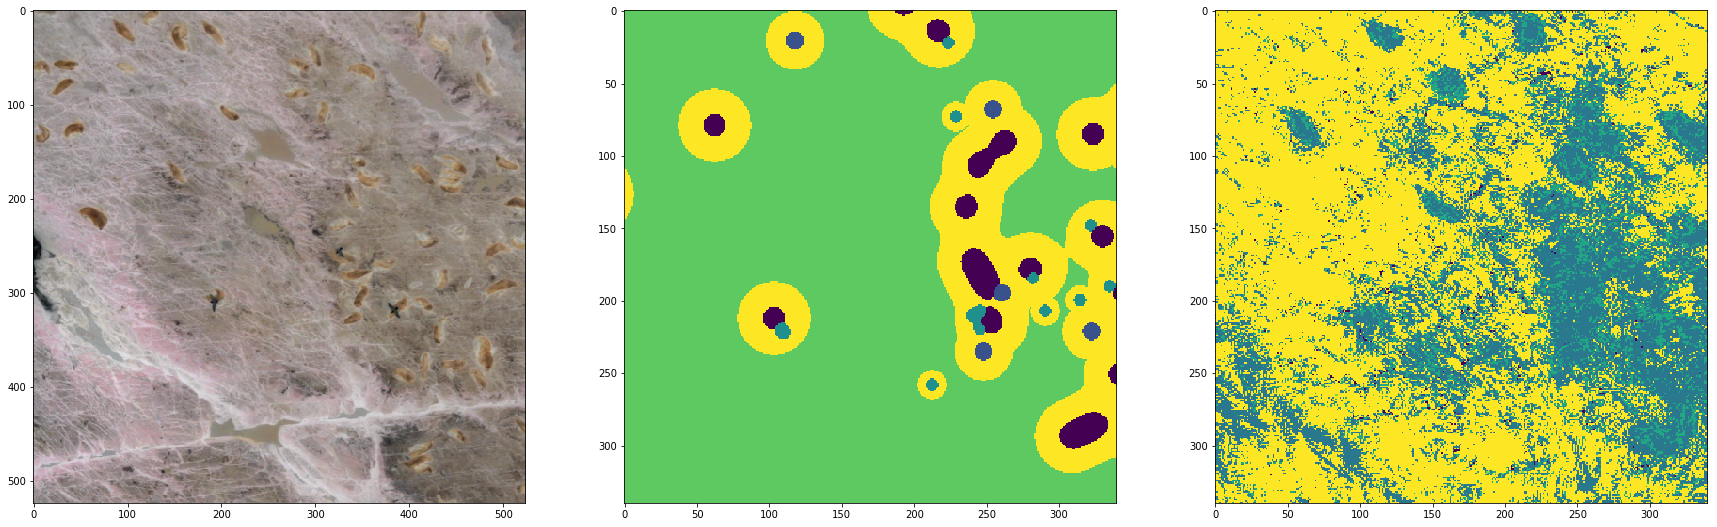

In [43]:
i = 6
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [46]:
weights_per_class = np.array([10, 10, 10, 10, 10, 1, 0]) #use a low weights for the background, to avoid learning all bg
sgd = SGD(lr=1e-5, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[1.0, 0.0], metrics=[accuracy_ignored])

In [47]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_bg_seg_{epoch:02d}-{val_loss:.2f}.h5")

In [48]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/5
200/200 [==============================] - 378s - loss: 0.8899 - segmentation_loss: 0.8899 - counts_loss: 133.9898 - segmentation_accuracy_ignored: 0.8881 - counts_accuracy_ignored: 0.2097 - val_loss: 0.8324 - val_segmentation_loss: 0.8324 - val_counts_loss: 80.5808 - val_segmentation_accuracy_ignored: 0.9171 - val_counts_accuracy_ignored: 0.2175
Epoch 2/5
200/200 [==============================] - 377s - loss: 0.8316 - segmentation_loss: 0.8316 - counts_loss: 115.1748 - segmentation_accuracy_ignored: 0.9125 - counts_accuracy_ignored: 0.2069 - val_loss: 0.7485 - val_segmentation_loss: 0.7485 - val_counts_loss: 64.6581 - val_segmentation_accuracy_ignored: 0.9130 - val_counts_accuracy_ignored: 0.1894
Epoch 3/5
200/200 [==============================] - 377s - loss: 0.7915 - segmentation_loss: 0.7915 - counts_loss: 87.0917 - segmentation_accuracy_ignored: 0.9176 - counts_accuracy_ignored: 0.1944 - val_loss: 0.7864 - val_segmentation_loss: 0.7864 - val_counts_loss: 70.5804 - val_

In [49]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break
y_pred, counts_pred = unet.predict(batch_x, batch_size=16)

True counts:  [0 1 0 7 0]
Pred counts:  [ 0.  0.  0.  0.  0.]


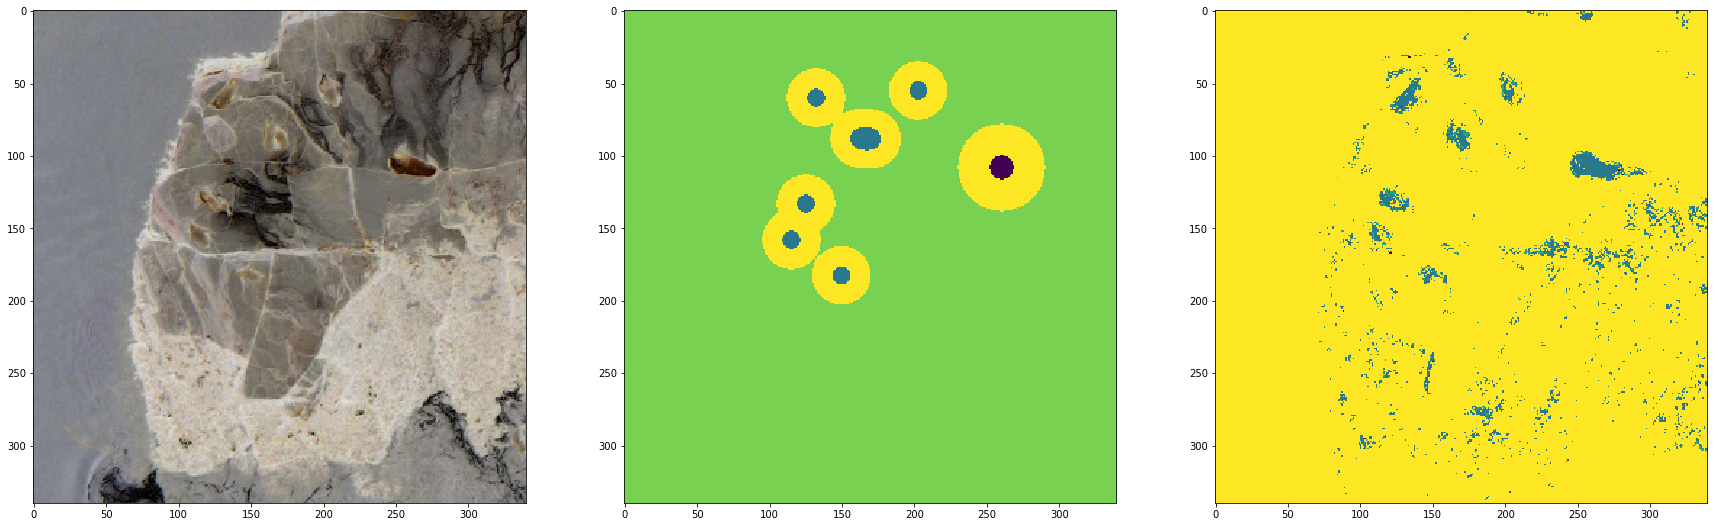

In [69]:
i = 5
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :])[92:-92, 92:-92,...])
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [70]:
np.unique(np.argmax(y_pred[i,...], axis=-1), return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([    16,     22,   3284,    551,      8, 111719]))

In [97]:
weights_per_class = np.array([30, 30, 5, 10, 30, 1, 0]) #use a low weights for the background, to avoid learning all bg
sgd = SGD(lr=1e-5, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[1.0, 0.0], metrics=[accuracy_ignored])

In [98]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_distribution_seg_{epoch:02d}-{val_loss:.2f}.h5")

In [99]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/5
200/200 [==============================] - 378s - loss: 0.9771 - segmentation_loss: 0.9771 - counts_loss: 116.4770 - segmentation_accuracy_ignored: 0.9406 - counts_accuracy_ignored: 0.1787 - val_loss: 0.9917 - val_segmentation_loss: 0.9917 - val_counts_loss: 99.8106 - val_segmentation_accuracy_ignored: 0.9432 - val_counts_accuracy_ignored: 0.1656
Epoch 2/5
200/200 [==============================] - 377s - loss: 0.9742 - segmentation_loss: 0.9742 - counts_loss: 98.4253 - segmentation_accuracy_ignored: 0.9428 - counts_accuracy_ignored: 0.1866 - val_loss: 0.9671 - val_segmentation_loss: 0.9671 - val_counts_loss: 71.0864 - val_segmentation_accuracy_ignored: 0.9440 - val_counts_accuracy_ignored: 0.1931
Epoch 3/5
200/200 [==============================] - 378s - loss: 0.9339 - segmentation_loss: 0.9339 - counts_loss: 119.9697 - segmentation_accuracy_ignored: 0.9432 - counts_accuracy_ignored: 0.2006 - val_loss: 0.9829 - val_segmentation_loss: 0.9829 - val_counts_loss: 86.0384 - val_

Now, let's train the the counts only

In [100]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_cnt_init_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/log_tb", batch_freq=10)

In [123]:
for l in unet.layers:
    l.trainable = True

In [124]:
adam = Adam()
cnt_net.compile(optimizer=adam, loss=mean_squared_error)

In [125]:
h = cnt_net.fit_generator(trainSegGenerator, 200, epochs=10,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valSegGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/10
200/200 [==============================] - 19s - loss: 198.8862 - val_loss: 2.5187
Epoch 2/10
200/200 [==============================] - 19s - loss: 100.0683 - val_loss: 77.4429
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 29.4711
Epoch 00002: reducing learning rate to 0.00010000000474974513.
200/200 [==============================] - 19s - loss: 29.3384 - val_loss: 25.1048
Epoch 4/10
200/200 [==============================] - 19s - loss: 2.6329 - val_loss: 0.7582
Epoch 5/10
200/200 [==============================] - 18s - loss: 0.8340 - val_loss: 0.7210
Epoch 6/10
200/200 [==============================] - 19s - loss: 1.0083 - val_loss: 1.3096
Epoch 7/10
200/200 [==============================] - 19s - loss: 1.2796 - val_loss: 0.6830
Epoch 8/10
200/200 [==============================] - 19s - loss: 2.0711 - val_loss: 2.2119
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.9915
Epoch 00008: reducing learning rate to 1.000000047

And finetune both

In [127]:
from keras.models import load_model, save_model

In [129]:
save_model(unet, "/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_both_0000.h5", include_optimizer=False)

In [140]:
unet = load_model("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_both_0000.h5",
                 {"OHELayer": OHELayer,
                 "SumLayer": SumLayer})

/home/ubuntu/virtualenvs/kaggle/lib/python3.5/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [141]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_both_{epoch:02d}-{val_loss:.2f}.h5")

In [142]:
weights_per_class = np.array([1, 1, 1, 1, 1, 1, 0])
sgd = SGD(lr=1e-8, momentum=0.9, decay=1e-6, nesterov=True)
adam = Adam(lr=0.00001)
unet.compile(optimizer=adam, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[1.0, 0.01], metrics=[accuracy_ignored])

In [143]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/5
200/200 [==============================] - 381s - loss: 0.8206 - segmentation_loss: 0.1521 - counts_loss: 66.8541 - segmentation_accuracy_ignored: 0.9618 - counts_accuracy_ignored: 0.3297 - val_loss: 0.6304 - val_segmentation_loss: 0.1368 - val_counts_loss: 49.3616 - val_segmentation_accuracy_ignored: 0.9647 - val_counts_accuracy_ignored: 0.3744
Epoch 2/5
200/200 [==============================] - 379s - loss: 0.6746 - segmentation_loss: 0.1266 - counts_loss: 54.8033 - segmentation_accuracy_ignored: 0.9649 - counts_accuracy_ignored: 0.3581 - val_loss: 0.7017 - val_segmentation_loss: 0.1390 - val_counts_loss: 56.2663 - val_segmentation_accuracy_ignored: 0.9576 - val_counts_accuracy_ignored: 0.4056
Epoch 3/5
199/200 [============================>.] - ETA: 1s - loss: 0.9982 - segmentation_loss: 0.1252 - counts_loss: 87.2998 - segmentation_accuracy_ignored: 0.9641 - counts_accuracy_ignored: 0.2764
Epoch 00002: reducing learning rate to 9.999999747378752e-07.
200/200 [============

In [155]:
unet = load_model("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_2x/ckpt_both_02-0.73.h5",
                 {"OHELayer": OHELayer,
                 "SumLayer": SumLayer,
                 "weighted_categorical_crossentropy": weighted_categorical_crossentropy,
                 "accuracy_ignored": accuracy_ignored})

In [156]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break
y_pred, counts_pred = unet.predict(batch_x, batch_size=16)

True counts:  [0 7 5 6 0]
Pred counts:  [ 1.5397197  -0.14096901  6.21709013  8.27082062 -0.06351973]


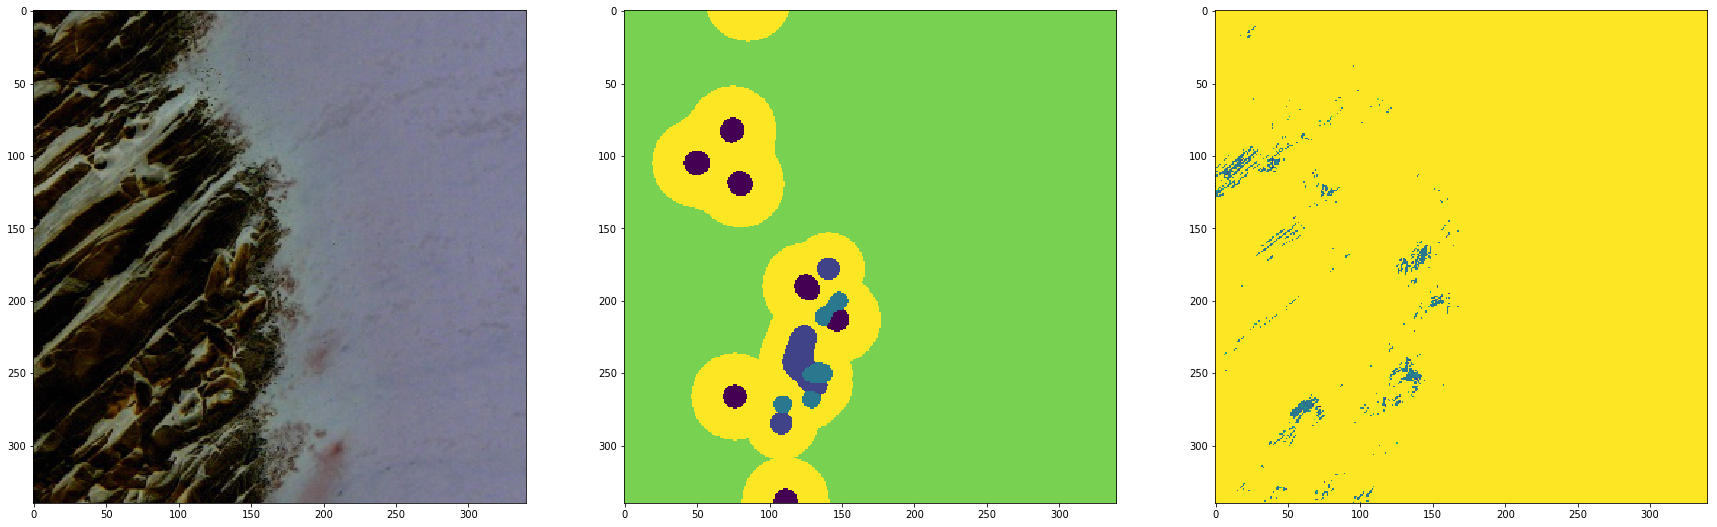

In [158]:
i = 0
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :])[92:-92, 92:-92,...])
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
for layer in unet.layers:
    layer.trainable = False
unet.get_layer(name="counts").trainable=True

In [ ]:
adam = Adam()
unet.compile(optimizer=adam, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[0, 1.0])

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_4x/ckpt_cnt_{epoch:02d}-{val_loss:.2f}.h5")

In [ ]:
hcnt = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Now, train with the 2 losses, and a higher weights for the background

In [ ]:
for layer in unet.layers:
    layer.trainable = True

In [ ]:
from keras.models import load_model

In [ ]:
unet = load_model("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_4x/ckpt_cnt_04-88.66.h5",
                  {"OHELayer":OHELayer,
                  "SumLayer":SumLayer,
                  "weighted_categorical_crossentropy": weighted_categorical_crossentropy})

In [ ]:
weights_per_class = np.array([10, 10, 5, 8, 10, 1, 0])
sgd = SGD(lr=1e-7, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, mean_squared_error], loss_weights=[1.0, 0.01], metrics=[accuracy_ignored])

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_2x_4x/ckpt_both_{epoch:02d}-{val_loss:.2f}.h5")

In [ ]:
hboth = unet.fit_generator(trainPatchesGenerator, 200, epochs=5,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

In [ ]:
from keras.models import load_model

In [ ]:
unet = load_model("/home/ubuntu/data/sealion/data/models/segmentation_small_count_4x/ckpt_01-0.25.h5")

In [ ]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break
y_pred, counts_pred = unet.predict(batch_x, batch_size=16)

In [ ]:
i = 10
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
def train(trainPatchesGenerator, net, n_batches=100):
    pixels_per_type = np.zeros((6, ), dtype=np.int64)
    counts_per_type = np.zeros((5, ), dtype=np.int32)
    
    for i, (batch_x, [batch_y, batch_counts]) in enumerate(trainPatchesGenerator):
        y_pred, _ = net.predict(batch_x, batch_size=16)
        classes, cnts = np.unique(np.argmax(y_pred, axis=-1).ravel(), return_counts=True)
        for c, cnt in zip(classes, cnts):
            pixels_per_type[int(c)] += cnt
        counts_per_type += np.sum(batch_counts, axis=0)

        if i == n_batches - 1:
            break
    print(counts_per_type)
    return counts_per_type/pixels_per_type[:-1]

In [ ]:
weights = train(trainPatchesGenerator, unet, 100)

In [ ]:
weights

In [ ]:
def predict(net, batch_x, weights):
    counts = np.zeros((batch_x.shape[0], weights.shape[0]))
    y_pred, _ = net.predict(batch_x, batch_size=16)
    y_pred = np.argmax(y_pred, axis=-1)
    for b in range(y_pred.shape[0]):
        classes, cnts = np.unique(y_pred[b], return_counts=True)
        pixels_per_type = np.zeros((6, ), dtype=np.int64)
        for c, cnt in zip(classes, cnts):
            pixels_per_type[int(c)] += cnt
        counts[b] = weights * pixels_per_type[:-1]
    
    return counts

In [ ]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break

In [ ]:
weights

In [ ]:
predict(unet, batch_x, weights)

In [ ]:
for l in unet.layers:
    l.trainable = False
unet.get_layer(name="ohe").trainable = True
unet.get_layer(name="scale").trainable = True
unet.get_layer(name="counts").trainable = True

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count_4x/ckpt_cnt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation_small_count_4x/log_tb", batch_freq=10)

In [ ]:
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, counts_mae], loss_weights=[0.0, 1.0], metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=2,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Now, the net is initialized, let's train with the 2 losses

In [ ]:
weights_per_class = np.array([10, 10, 10, 10, 10, 1, 0]) # increase weight for the background
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, counts_mae], loss_weights=[1.0, 1.0], metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=2,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

In [ ]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break
y_pred, counts_pred = unet.predict(batch_x, batch_size=16)

In [ ]:
i = 15
plt.figure(figsize=(3 * 10, 10))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
yc_true = K.constant(batch_counts)
yc_pred = K.constant(counts_pred)

In [ ]:
with sess.as_default():
    print(np.sqrt(np.mean(mean_squared_error(yc_true, yc_pred).eval())))

In [ ]:
for l in unet.layers:
    l.trainable = True

In [ ]:
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, counts_mae], loss_weights=[1.0, 1.0], metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=2,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

In [ ]:
# Actual training

In [ ]:
for l in unet.layers:
    l.trainable = True

In [ ]:
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, counts_mae], loss_weights=[1.0, 1.0], metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

In [ ]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break

In [ ]:
y_pred, counts_pred = unet.predict(batch_x)

In [ ]:
i = 15
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
y_true = K.constant(batch_counts)
y_pred = K.constant(counts_pred)

In [ ]:
with sess.as_default():
    print(np.mean(mean_squared_error(y_true, y_pred).eval()))

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")